# Capstone: Bitcoin: Time Series Forecasting Using Machine Learning

## 3.3 Modeling - Recurrent Neural Network (LSTM) - BTC
---

Long Short Term Memory networks are a special kind of RNN that are capable of learning long-term dependencies.
LSTMs are explicitly designed to avoid the long-term dependency problem, so they have a memory component to learn long-term behavior.
Let's see how it does with Bitcoin's price data.

## Imports
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

import _pickle as pickle

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

### Loading the Data

In [2]:
with open("curr_bitcoin.pickle",'rb') as fp:
    df = pickle.load(fp)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3777 entries, 2010-07-17 to 2020-11-17
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3777 non-null   float64
 1   High    3777 non-null   float64
 2   Low     3777 non-null   float64
 3   Open    3777 non-null   float64
dtypes: float64(4)
memory usage: 147.5 KB


In [4]:
df.tail()

,Close,High,Low,Open
Date,,,,
2020-11-13,16311.513323,16462.716548,15992.152801,16292.717048
2020-11-14,16075.452734,16314.263353,15776.768439,16314.263353
2020-11-15,15962.098952,16119.264673,15793.533917,16063.671431
2020-11-16,16709.612284,16804.409142,15887.108131,15953.998053
2020-11-17,17667.381593,17782.620109,16564.544992,16700.900927


## Preprocessing Data

In [5]:
# Only selecting the 'Close' column
df = df[['Close']]

In [6]:
# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [7]:
# Checking the newly formatted DataFrame
df.head()

,Close
Date,
2010-07-17,0.000000
2010-07-18,0.000002
2010-07-19,0.000002
2010-07-20,0.000001
2010-07-21,0.000002


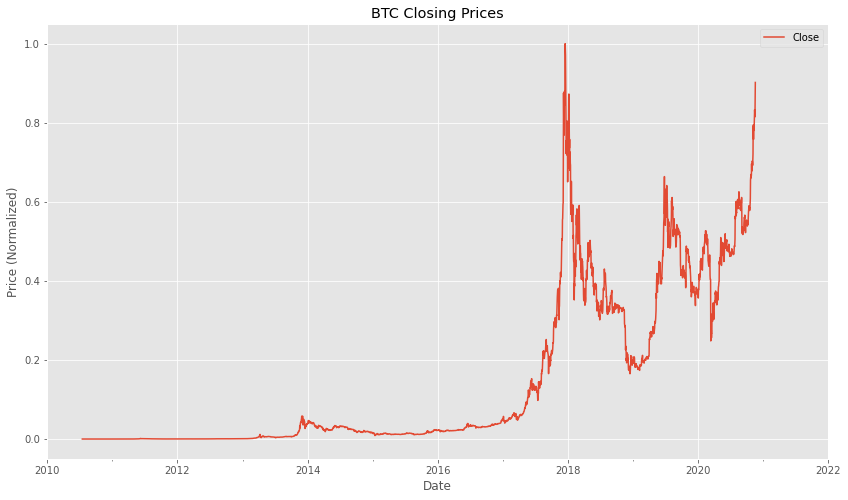

In [8]:
# Plotting the Closing Prices
df.plot(figsize=(14,8), xlim=('2010','2022'))
plt.title("BTC Closing Prices")
plt.ylabel("Price (Normalized)")
plt.show()

### Custom fuctions to prepare data for LSTM

In [9]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [10]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [11]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

### Splitting the Data

In [12]:
# How many periods looking back to learn
n_per_in  = 60

# How many periods to predict
n_per_out = 30

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [13]:
X.shape

(3688, 60, 1)

## Modeling - LSTM (RNN)

### Creating the Neural Network

In [14]:
# Instatiating the model
model = Sequential()

# Activation
activ = 'softsign'

# Input layer
model.add(LSTM(256, return_sequences=True, activation=activ, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=2, n_nodes=128,  activation=activ, drop=1, d_rate=0.1)

# Final Hidden layer
model.add(LSTM(10))

# Output layer
model.add(Dense(n_per_out))

# Model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 256)           264192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           197120    
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                5560      
_________________________________________________________________
dense (Dense)                (None, 30)                3

In [15]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [16]:
res = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1,
                callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5,
                                           patience=20, verbose=1)])

Epoch 1/100
104/104 [==============================] - 108s 1s/step - loss: 0.0181 - accuracy: 0.0322 - val_loss: 0.0221 - val_accuracy: 0.0325
Epoch 2/100
104/104 [==============================] - 65s 630ms/step - loss: 0.0032 - accuracy: 0.0226 - val_loss: 0.0098 - val_accuracy: 0.0407
Epoch 3/100
104/104 [==============================] - 85s 818ms/step - loss: 0.0023 - accuracy: 0.0350 - val_loss: 0.0063 - val_accuracy: 0.0352
Epoch 4/100
104/104 [==============================] - 71s 685ms/step - loss: 0.0021 - accuracy: 0.0316 - val_loss: 0.0059 - val_accuracy: 0.0569
Epoch 5/100
104/104 [==============================] - 82s 784ms/step - loss: 0.0021 - accuracy: 0.0319 - val_loss: 0.0051 - val_accuracy: 0.0163
Epoch 6/100
104/104 [==============================] - 99s 955ms/step - loss: 0.0020 - accuracy: 0.0383 - val_loss: 0.0047 - val_accuracy: 0.0407
Epoch 7/100
104/104 [==============================] - 112s 1s/step - loss: 0.0022 - accuracy: 0.0325 - val_loss: 0.0055 - val

### Plotting the Accuracy and Loss

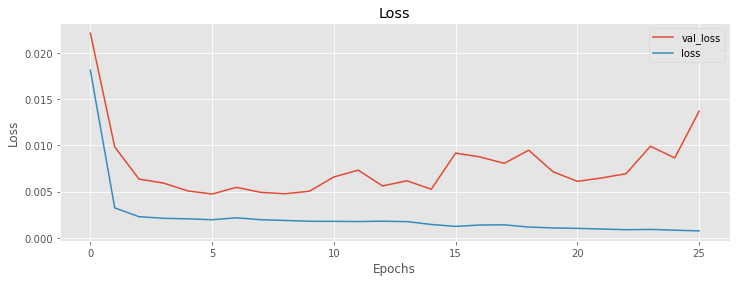

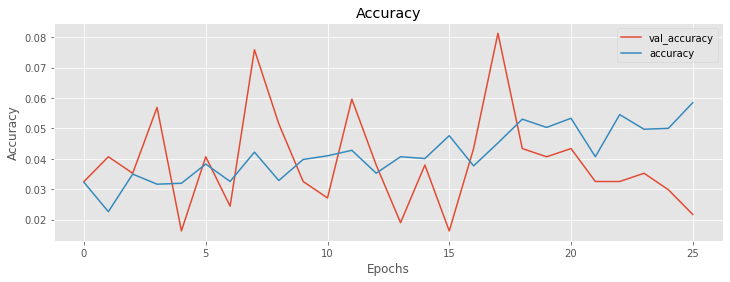

In [17]:
visualize_training_results(res)

## Visualizing the Predictions

### Validating the Model 
Plotting the difference between the Actual closing prices and the Predicted prices

Predicted Prices:
 [[9629.281621653961], [9215.050893210795], [9707.142266962524], [9404.96445980584], [9152.23828181135], [9060.113001674514], [9345.955011604387], [8807.200605865723], [9045.422225766497], [8751.473611488113], [8910.840451479218], [8773.60025736022], [8738.36422761438], [8783.810130626976], [8356.049714779372], [8381.689397662305], [8745.56542810716], [8649.327594673337], [8619.239699423755], [8681.885940675631], [8600.139238972739], [8468.079285869702], [8239.39446983165], [7698.379765105629], [7966.622148442052], [8046.259159922757], [8034.260077875976], [8033.747541070476], [7802.317909474946], [7890.123987078864]]

Actual Prices:
 [[11742.056464068412], [11916.334474515825], [12823.721613011156], [12965.938910967061], [12928.422292893309], [13112.518308892804], [13025.152726171284], [13072.25343050888], [13638.61347118853], [13274.1015514869], [13449.310773172034], [13567.751090472695], [13779.026945510965], [13712.17922675368], [13558.759567504292], [13914.806921

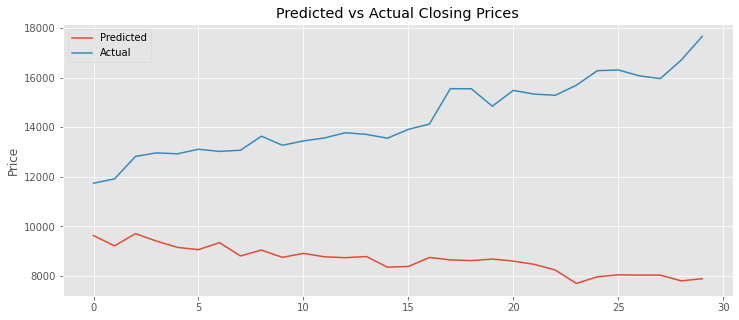

In [18]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

### Predicting/Forecasting the future prices

                   Close
2020-11-17  13477.121917
2020-11-18  13794.180221
2020-11-19  13596.067817
2020-11-20  13488.320672
2020-11-21  13166.146340
2020-11-22  13061.939085
2020-11-23  13510.906149
2020-11-24  12395.208091
2020-11-25  12904.343941
2020-11-26  12853.487214
2020-11-27  12597.755865
2020-11-28  12991.709867
2020-11-29  12876.568883
2020-11-30  13090.176477
2020-12-01  11823.930365
2020-12-02  12406.409181
2020-12-03  12400.759601
2020-12-04  12504.580410
2020-12-05  12647.190566
2020-12-06  12522.260011
2020-12-07  12370.425361
2020-12-08  12330.448657
2020-12-09  12249.027691
2020-12-10  11529.792614
2020-12-11  11612.994033
2020-12-12  12369.350084
2020-12-13  11880.262713
2020-12-14  11710.004758
2020-12-15  11305.330681
2020-12-16  11589.914699


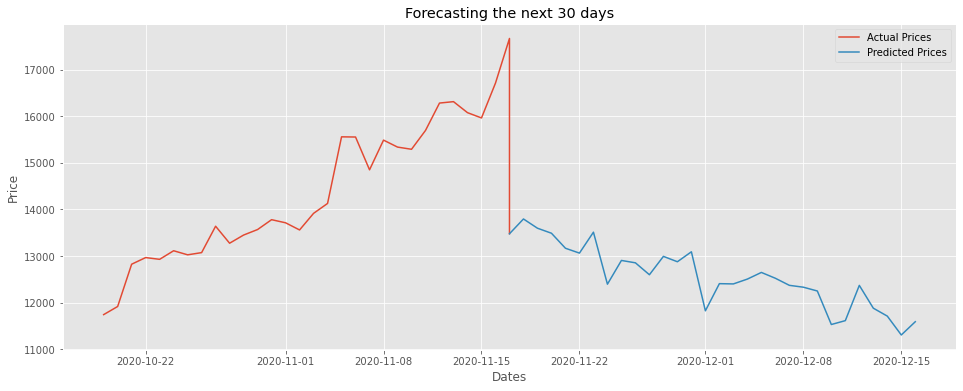

In [19]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 30

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()

### With Train Test Split

In [20]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [21]:
train, test = train_test_split(df, test_size=0.1)

In [22]:
# train, test = df[:3455], df[3455:]

In [23]:
train.shape, test.shape

((3400, 1), (377, 1))

In [24]:
# How many periods looking back to learn
n_per_in  = 60

# How many periods to predict
n_per_out = 30

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X_train, y_train = split_sequence(list(train.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

In [25]:
# Splitting the data into appropriate sequences
X_test, y_test = split_sequence(list(test.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [26]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3311, 60, 1), (3311, 30), (288, 60, 1), (288, 30))

## Modeling - LSTM (RNN)

### Creating the Neural Network

In [27]:
# Instatiating the model
model = Sequential()

# Activation
activ='softsign'

# Input layer
model.add(LSTM(256, return_sequences=True,  activation=activ, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=4, n_nodes=256,  activation=activ, drop=1, d_rate=0.2)

# Final Hidden layer
model.add(LSTM(10))

# Output layer
model.add(Dense(1))

# Model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 256)           264192    
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 256)           525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 256)           525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 256)           525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 256)          

In [28]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [ ]:
res = model.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=False,
                validation_data=(X_test, y_test),
                callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5,
                                           patience=20, verbose=1)])

Epoch 1/100
104/104 [==============================] - 107s 1s/step - loss: 0.0095 - accuracy: 2.6175e-04 - val_loss: 0.0091 - val_accuracy: 0.0000e+00
Epoch 2/100
104/104 [==============================] - 104s 999ms/step - loss: 0.0265 - accuracy: 0.0000e+00 - val_loss: 0.0113 - val_accuracy: 0.0000e+00
Epoch 3/100
104/104 [==============================] - 102s 985ms/step - loss: 0.0294 - accuracy: 0.0000e+00 - val_loss: 0.0721 - val_accuracy: 0.0000e+00
Epoch 4/100
104/104 [==============================] - 99s 954ms/step - loss: 0.0295 - accuracy: 0.0000e+00 - val_loss: 0.0213 - val_accuracy: 0.0000e+00
Epoch 5/100
104/104 [==============================] - 99s 957ms/step - loss: 0.0315 - accuracy: 0.0000e+00 - val_loss: 0.0335 - val_accuracy: 0.0000e+00
Epoch 6/100
104/104 [==============================] - 103s 992ms/step - loss: 0.0278 - accuracy: 0.0000e+00 - val_loss: 0.0175 - val_accuracy: 0.0000e+00
Epoch 7/100
104/104 [==============================] - 101s 969ms/step - lo

### Plotting the Accuracy and Loss

In [ ]:
visualize_training_results(res)

## Visualizing the Predictions

### Validating the Model 
Plotting the difference between the Actual closing prices and the Predicted prices

In [ ]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat_train = model.predict(X_train[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat_train = scaler.inverse_transform(np.array(yhat_train).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y_train[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat_train)
plt.plot(yhat_train, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

### Predicting/Forecasting the future prices

In [ ]:
# Predicting off of y because it contains the most recent dates
yhat_test = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat_test = scaler.inverse_transform(np.array(yhat_test).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat_test, index=pd.date_range(start=df.index[-1], periods=len(yhat_test), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 50

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat_test)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [ ]:
# https://activewizards.com/blog/bitcoin-price-forecasting-with-deep-learning-algorithms/
trace1 = go.Scatter(
    x = np.arange(0, len(res.history['loss']), 1),
    y = res.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(res.history['val_loss']), 1),
    y = res.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training',
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')

In [ ]:
working_data = [train, test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['Date'] = pd.to_datetime(working_data['Date'])
working_data = working_data.set_index('Date')

In [ ]:
import statsmodels.api as sm
s = sm.tsa.seasonal_decompose(working_data.Close.values, period=60)

In [ ]:
trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

In [ ]:
y_test.shape, X_test.shape

In [ ]:
# # Making the predictions
# test_set = X_test.values
# inputs = np.reshape(test_set, (len(test_set), 1))
# inputs = sc.transform(inputs)
# inputs = np.reshape(X_test, (len(X_test), 1, 1))

In [ ]:
predicted_BTC_price = model.predict(X_test)
predicted_BTC_price = scaler.inverse_transform(predicted_BTC_price)

In [ ]:
len(predicted_BTC_price) , len(test), X_test.shape

In [ ]:
with open("curr_bitcoin.pickle",'rb') as fp:
    btc = pickle.load(fp)

In [ ]:
predicted_BTC_price.shape, test.shape

In [ ]:
# test['Price_Prediction'] = predicted_BTC_price
# data_all = pd.concat([test, train], sort=False)

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(btc['Close'])

In [ ]:
# add one additional data point to align shapes of the predictions and true labels
# X_test = np.append(X_test, scaler.transform(working_data.iloc[-1][0]))
# X_test = np.reshape(X_test, (len(X_test), 1, 1))

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
y_test2_inverse = np.array(y_test_inverse[:,0])

In [ ]:
trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted labels',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(y_test2_inverse), 1),
    y = y_test2_inverse,
    mode = 'lines',
    name = 'True labels',
    line = dict(color=('rgb(66, 244, 155)'), width=1)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

In [ ]:
# rmse = np.sqrt(mean_squared_error(y_test2_inverse[:-1], prediction2_inverse))
# # print('Test RMSE: %.3f' % rmse)
# mae = mean_absolute_error(y_test2_inverse[:-1], prediction2_inverse)
# print('Test MAE: %.3f' % mae)

In [ ]:
y_test2_inverse

In [ ]:
prediction2_inverse.shape

In [ ]:
y_test2_inverse.shape

In [ ]:
Test_Dates = df[len(df)-len(test):].index

trace1 = go.Scatter(x=Test_Dates, y=y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=prediction2_inverse, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

In [ ]:
#Lets do the prediction and performance checking
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
#transformation to original form
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
train_predict_inv = scaler.inverse_transform(train_predict)
test_predict_inv = scaler.inverse_transform(test_predict)

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(y_train_inv.flatten(), marker='.', label="Actual", color='blue')
plt.plot(train_predict_inv.flatten(), 'r', marker='.', label="Predicted")
plt.legend();

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(y_test_inv.flatten(), marker='.', label="Actual")
plt.plot(test_predict_inv.flatten(), 'r', marker='.', label="Predicted")
plt.legend()

In [ ]:
# train_RMSE = np.sqrt(mean_squared_error(y_train, train_predict))
# test_RMSE = np.sqrt(mean_squared_error(y_test, test_predict))
# train_MAE = mean_absolute_error(y_train, train_predict)
# test_MAE = mean_absolute_error(y_test, test_predict)


# print(f"Train RMSE: {train_RMSE}")
# print(f"Train MAE: {train_MAE}")

# print(f"Test RMSE: {test_RMSE}")
# print(f"Test MAE: {test_MAE}")

<a id="section-seven"></a>
# Model Selection and Prediction

We observed remarkable results using LSTMs. They really work a lot better for most sequence tasks! 

Let's predict weighted price for next 30 days. 

In [ ]:
test.shape

In [ ]:
lookback = len(test) - 100
x_input=np.array(test[lookback:]).reshape(1,-1)
x_input.shape

In [ ]:
x_input

In [ ]:
lookback, len(test)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

In [ ]:
len(temp_input)

In [ ]:
# demonstrate prediction for next 100 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

In [ ]:
len(df)

In [ ]:
df_=np.array(df).tolist()
df_.extend(lst_output)
plt.plot(df_)

In [ ]:
plt.figure(figsize=(14,7))
df_invscaled=scaler.inverse_transform(df_).tolist()
plt.plot(df_invscaled)

In [ ]:
with open("btc_coinmetrics.pickle",'rb') as fp:
    btc = pickle.load(fp)

In [ ]:
btc

In [ ]:
with open("hourly_ohlc_price_glassnode.pickle",'rb') as fp:
    hr = pickle.load(fp)

In [ ]:
hr.info()

In [ ]:
hr.head()

In [ ]:
hr = hr['Close']

In [ ]:
hr.fillna(method='bfill', inplace=True)

In [ ]:
dataset = hr.values
dataset = dataset.astype('float32')

In [ ]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(hr)